In [155]:
import scipy.io as io
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from scipy.stats import binned_statistic_2d
from sklearn.decomposition import NMF

sns.set_style('whitegrid')

%matplotlib inline

## Set parameters of the model and visualize it

In [156]:
D = 6 # size of RF
T = 10000 # number of time steps
dt = 0.01 # size of time step in s
R = 10 # firing rate in Hz

In [157]:
k = np.zeros((D,D))

# subunits
k1 = k.copy()
k1[2,2:4] = 1
k1 = k1.flatten()

k2 = k.copy()
k2[3,2:4] = 1
k2=k2.flatten()

w = np.array([.5, .5])

# linear receptive field 
ks = np.concatenate((k1[:,np.newaxis],k2[:,np.newaxis]),axis=1) 
k = ks @ w

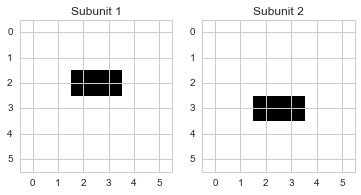

In [158]:
plt.subplot(1,2,1)
plt.imshow(k1.reshape(D,D),interpolation='nearest')
plt.title('Subunit 1')

plt.subplot(1,2,2)
plt.imshow(k2.reshape(D,D),interpolation='nearest')
plt.title('Subunit 2')

## Simulate responses to Gaussian noise

In [159]:
# create stimulus
np.random.seed(10)
s = np.random.normal(0,1,(D**2,T))

In [160]:
#generate responses from subunit model
rs = np.exp(ks.transpose() @ s) * dt * R 
r = w.transpose() @ rs

np.random.seed(4000)
sp = np.random.poisson(r) 


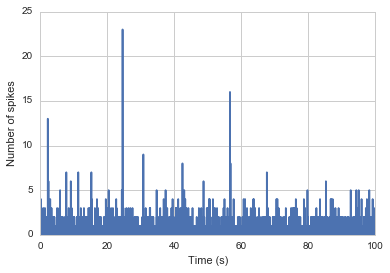

In [161]:
t = np.arange(0,T) * dt;
plt.plot(t,sp)
plt.xlabel('Time (s)')
plt.ylabel('Number of spikes')

## Finding subunits with kmeans

In [162]:
ste = np.zeros((s.shape[0],0))
for i,n in enumerate(sp):
    if n>0:
        ss = s[:,i]
        tmp = np.kron(np.ones((1,n)),ss[:,np.newaxis])
        ste = np.concatenate((ste,tmp),axis=1)
        
ste.shape

sta = np.mean(ste,axis=1)
    

In [163]:
k_means = KMeans(n_clusters=2)
k_means.fit(ste.transpose())

k1_est = k_means.cluster_centers_[0,:]
k2_est = k_means.cluster_centers_[1,:]
#k3_est = k_means.cluster_centers_[2,:]


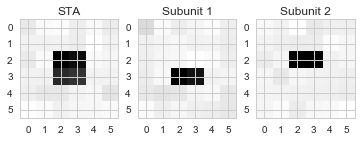

In [164]:
plt.subplot(1,3,1)
plt.imshow(sta.reshape(D,D),interpolation='nearest')
plt.title('STA')

plt.subplot(1,3,2)
plt.imshow(k1_est.reshape(D,D),interpolation='nearest')
plt.title('Subunit 1')

plt.subplot(1,3,3)
plt.imshow(k2_est.reshape(D,D),interpolation='nearest')
plt.title('Subunit 2')

#plt.subplot(1,4,4)
#plt.imshow(k3_est.reshape(D,D),interpolation='nearest')
#plt.title('Subunit 3')


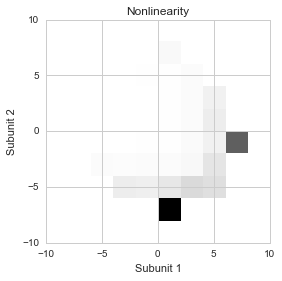

In [165]:
r1_est = k1_est.transpose() @ s
r2_est = k2_est.transpose() @ s

ret = binned_statistic_2d(r1_est,r2_est,sp,range=[[-10,10],[-10,10]],bins=10)
mns = ret.statistic
xb = ret.x_edge
yb = ret.y_edge

plt.imshow(mns, interpolation='nearest', extent=[-10,10,-10,10])
plt.title('Nonlinearity')
plt.xlabel('Subunit 1')
plt.ylabel('Subunit 2')

## NMF

In [166]:
nmf_mod = NMF(n_components=2)
nmf_mod.fit(ste.transpose()+np.abs(np.min(ste)))

k1_est = nmf_mod.components_[0,:]
k2_est = nmf_mod.components_[1,:]



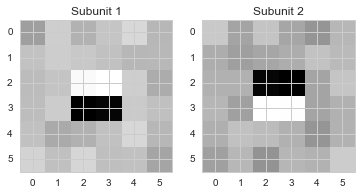

In [167]:
plt.subplot(1,2,1)
plt.imshow(k1_est.reshape(D,D),interpolation='nearest')
plt.title('Subunit 1')

plt.subplot(1,2,2)
plt.imshow(k2_est.reshape(D,D),interpolation='nearest')
plt.title('Subunit 2')

## Gaussian mixture model

In [168]:
g_mm = GMM(n_components=2,covariance_type='diag')
g_mm.fit(ste.transpose())

k1_est = g_mm.means_[0,:]
k2_est = g_mm.means_[1,:]


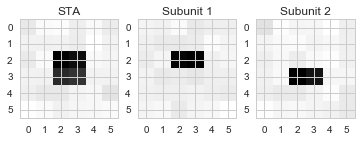

In [169]:
plt.subplot(1,3,1)
plt.imshow(sta.reshape(D,D),interpolation='nearest')
plt.title('STA')

plt.subplot(1,3,2)
plt.imshow(k1_est.reshape(D,D),interpolation='nearest')
plt.title('Subunit 1')

plt.subplot(1,3,3)
plt.imshow(k2_est.reshape(D,D),interpolation='nearest')
plt.title('Subunit 2')


 ## Iterative algorithm by Shlens et al.
 
 For some reason, this does not work - rather, the algorithm walks away even from the correct solution. I guess something must be wrong.

In [ ]:
#for i in range(1,1000):
tmp = w[:,np.newaxis] * (np.exp(ks_est.transpose() @ s))

alpha = tmp/np.sum(tmp,axis=0)

ks_est = (s @ alpha.transpose()) / np.sum(alpha,axis=1)

w_est = np.sum(alpha,axis=1) / T * np.exp(-.5 * np.linalg.norm(ks_est,axis=0)**2)  